# Scattering covariance synthesis

In this notebook, we intend to do simple tests with scattering covariance synthesis:
* Gaussian field (ex: CMB) + synthesis with only P00 => Gaussian field and same Power Spectrum (PS)
* Non Gaussian field (ex: Venus) + synthesis with only P00 => Gaussian field and same PS
* Gaussian field + synthesis with all coeffs => Gaussian field and same PS
* Non Gaussian field + synthesis with all coeffs => Non Gaussian field and same PS


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from importlib import reload

import foscat.Synthesis as synthe
import foscat.scat_cov as sc
import almscat.Sphere_lib as sphlib

In [24]:
import tensorflow as tf
print('Num GPUs Available:', len(tf.config.experimental.list_physical_devices('GPU')))
print('Available devices:', tf.config.list_physical_devices())


Num GPUs Available: 0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Get data

In [25]:
# DEFINE A PATH FOR scratch data
# The data are stored using a default nside to minimize the needed storage
scratch_path = '../data'
nout = 32  # NSIDE

Mean and STD: 0.000 and 1.000


<Figure size 1000x600 with 0 Axes>

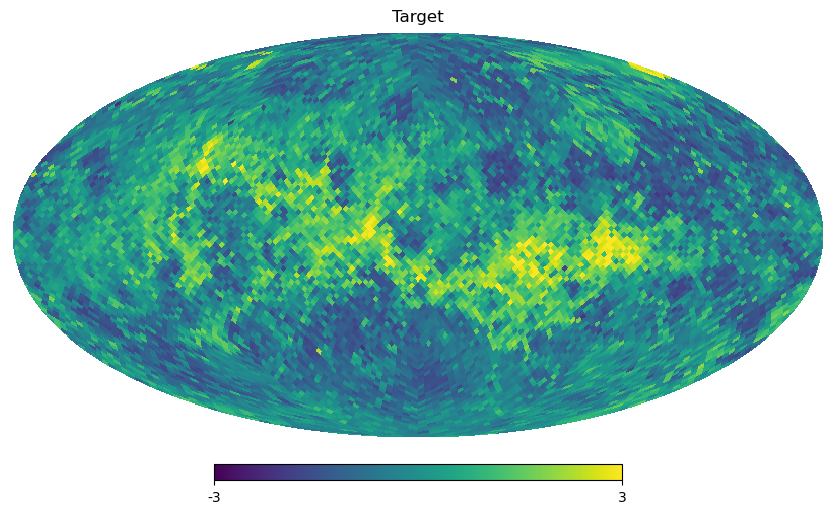

In [32]:
##### TARGET MAP: Choose between a Gaussian or a non Gaussian field
#tmap = sphlib.make_hpx_sky(nside=nout, sky_type='cmb', normalize=True, nest=True)  # CMB
tmap = sphlib.make_hpx_planet(nside=nout, planet='venus', interp=True, normalize=True, nest=True)  # Venus

# Plot the healpix map
plt.figure(figsize=(10, 6))
hp.mollview(tmap, cmap='viridis', nest=True, title='Target', min=-3, max=3)  # viridis, inferno, plasma, magma

# INITIALIZE FoCUS class

In [69]:
reload(sc)
scat_op = sc.funct(NORIENT=3,   # define the number of wavelet orientation
                   KERNELSZ=3,  # define the kernel size (here 5x5)
                   OSTEP=-1,     # get very large scale (nside=1)
                   LAMBDA=1.,
                   TEMPLATE_PATH=scratch_path,
                   slope=1.,
                   use_R_format=True,
                   all_type='float32')


          START FOSCAT CONFIGURATION
Num GPUs Available:  0
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : CPU:0                          ==
==                                                        ==
==                                                        ==


# Initialize the loss

In [70]:
# Write the loss function
def lossP00(x, scat_op, args):

    tP00 = args[0]
    norm = args[1]

    # Compute P00 on the iterating image
    xP00 = scat_op.eval(x, image2=None, norm=norm).P00

    loss = scat_op.reduce_sum(scat_op.square(xP00 - tP00))

    return loss

def lossAll(x, scat_op, args):

    tcoeff = args[0]
    norm = args[1]

    # Compute P00 on the iterating image
    xcoeff = scat_op.eval(x, image2=None, norm=norm)

    loss = scat_op.reduce_sum(scat_op.square(xcoeff - tcoeff))
    return loss

In [71]:
# Choose the normalisation
norm = 'auto'

# Compute the auto coeffs of the target image
scat_op.clean_norm()
tcoeff = scat_op.eval(tmap, image2=None, norm=norm)
tP00 = tcoeff.P00

# Choose the loss
loss = synthe.Loss(lossAll, scat_op, tcoeff, norm)
# loss = synthe.Loss(lossP00, scat_op, tP00, norm)

# Build the synthesis class
sy = synthe.Synthesis([loss])

../data/W25_1_IDX.npy COMPUTED
../data/W9_1_IDX.npy COMPUTED
../data/BRD2_1_FIDX.npy COMPUTED
../data/BRD2_1_FIDX1.npy COMPUTED
../data/BRD2_1_FIDX2.npy COMPUTED
../data/BRD2_1_FIDX3.npy COMPUTED
../data/BRD2_1_FIDX4.npy COMPUTED


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


# Run the synthesis

In [74]:
### Initial condition MAP
# Fix the seed
np.random.seed(42)

# Gaussian noise with the target PS
cl = hp.anafast(hp.reorder(tmap, n2r=True))
imap = hp.reorder(hp.synfast(cl, nout), r2n=True)

# Make white gaussian noise
# imap = np.random.randn(12*nout*nout)


In [75]:
### Run the synthesis
omap = sy.run(imap,
              DECAY_RATE=0.9998,
              NUM_EPOCHS = 30,
              LEARNING_RATE = 0.03,
              EPSILON = 1E-16)

Total number of loss  1
Itt 0 L=9.06 (9.06 ) 0.142s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
/home/lmousset/lib/FOSCAT/src/foscat/Synthesis.py:160: UserWarning: loadtxt: input contained no data: "smi_tmp.txt"
  return np.loadtxt('smi_tmp.txt')
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


# Check the synthesis

In [76]:
# Compute the coeff
icoeff = scat_op.eval(imap, image2=None, norm=norm)
ocoeff = scat_op.eval(omap, image2=None, norm=norm)

tP00 = tcoeff.P00.numpy().squeeze()
iP00 = icoeff.P00.numpy().squeeze()
oP00 = ocoeff.P00.numpy().squeeze()

sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


### Plot the maps

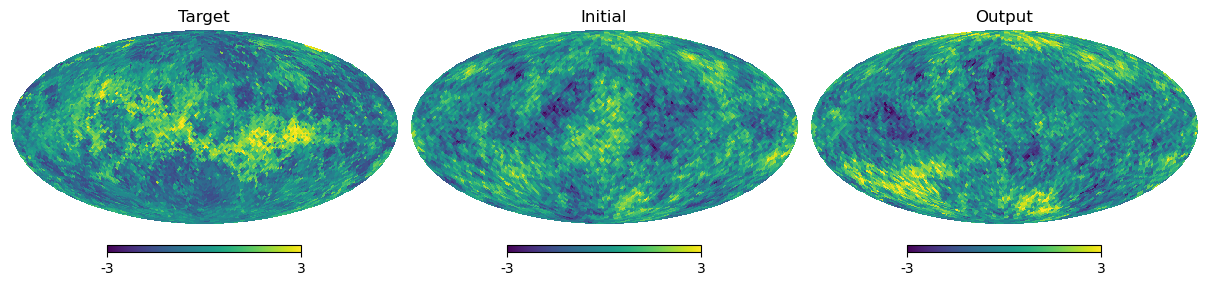

In [77]:
plt.figure(figsize=(12, 4))
hp.mollview(tmap, cmap='viridis', hold=False, sub=(1, 3, 1), nest=True, title='Target', min=-3, max=3)
hp.mollview(imap, cmap='viridis', hold=False, sub=(1, 3, 2), nest=True, title='Initial', min=-3, max=3)
hp.mollview(omap.numpy(), cmap='viridis', hold=False, sub=(1, 3, 3), nest=True, title='Output', min=-3, max=3)

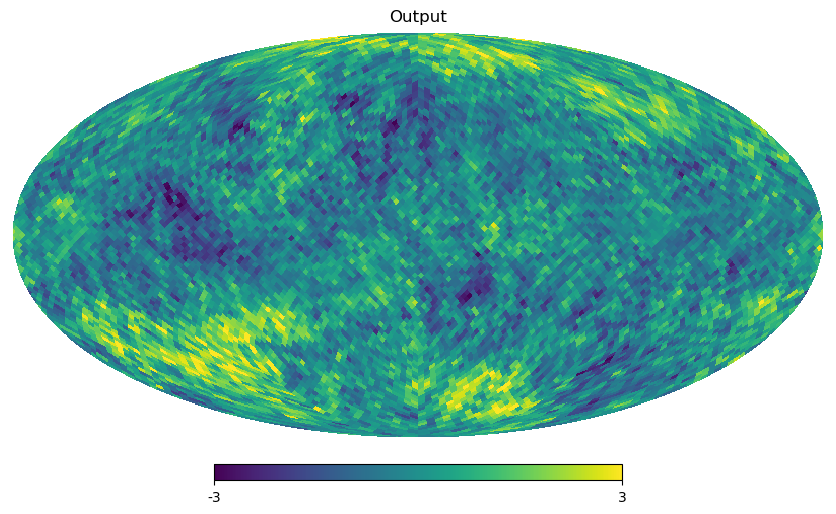

In [78]:
hp.mollview(omap.numpy(), cmap='viridis', hold=False, nest=True, title='Output', min=-3, max=3)

### Plot all coeffs

sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


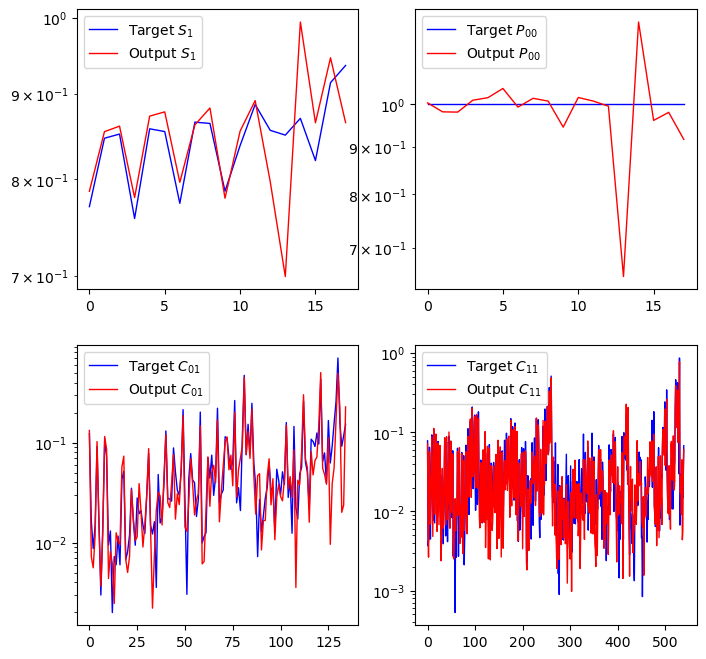

In [79]:
tcoeff.plot(color='b', name='Target')
# icoeff.plot(hold=False, color='g', name='Initial')
ocoeff.plot(hold=False, color='r', name='Output')


### Plot P00

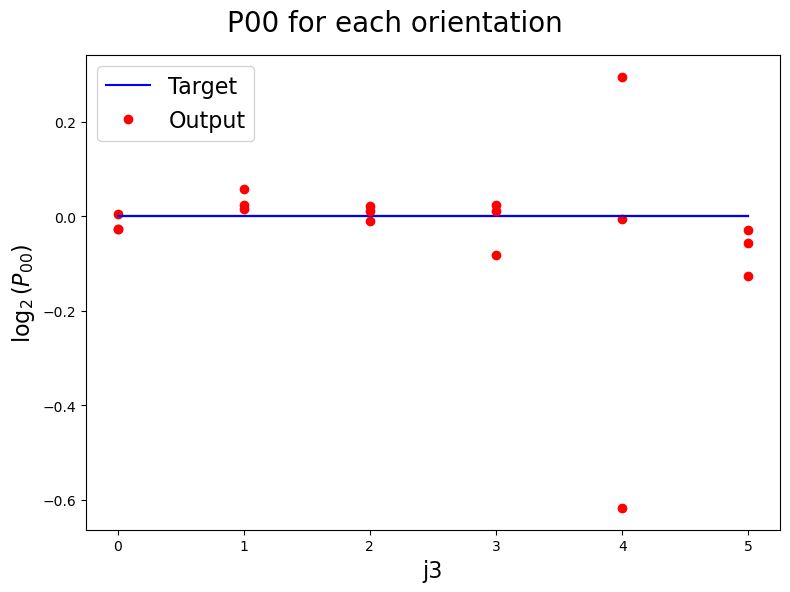

In [80]:
fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('P00 for each orientation',  fontsize=20)

for i in range(scat_op.NORIENT):
    ax0.plot(np.log2(tP00[:, i]), color='blue',label='Target')
    # ax0.plot(np.log2(gP00[:, i]), color='g',label='Initial')
    ax0.plot(np.log2(oP00[:, i]), 'o', color='red',label='Output')
    if i == 0:
        ax0.legend(fontsize=16)
ax0.set_xlabel('j3', fontsize=16)
ax0.set_ylabel(r'$\log_2(P_{00})$', fontsize=16)

fig.tight_layout()

### Angular power spectrum

sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Text(0, 0.5, '$C_\\ell$')

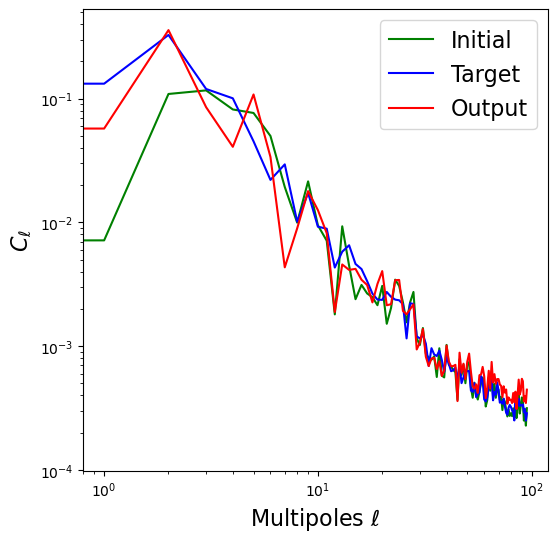

In [81]:
idx = hp.ring2nest(nout, np.arange(12*nout**2))

cli = hp.anafast((imap - np.median(imap))[idx])
clt = hp.anafast((tmap - np.median(tmap))[idx])
clo = hp.anafast((omap.numpy() - np.median(omap.numpy()))[idx])

plt.figure(figsize=(6,6))
plt.plot(cli,color='green',label=r'Initial')
plt.plot(clt,color='blue',label=r'Target')
plt.plot(clo,color='red',label=r'Output')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xlabel(r'Multipoles $\ell$', fontsize=16)
plt.ylabel(r'$C_\ell$', fontsize=16)

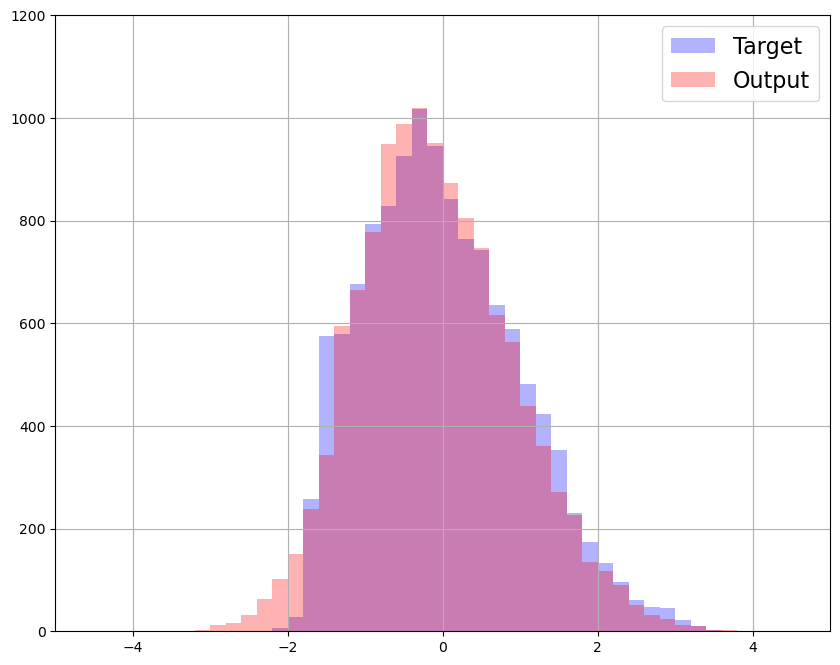

In [67]:
def plot_histo(target_hpx, synthetic_hpx, bins=50, range=(-5, 5), ymax=5000, fontsize=16):
    plt.figure(figsize=(10, 8))
    plt.hist(target_hpx.ravel(), bins=bins, range=range, color='b', alpha=0.3, label='Target')
    plt.hist(synthetic_hpx.ravel(), bins=bins, range=range, color='r', alpha=0.3, label='Output')
    plt.legend(fontsize=fontsize)
    plt.ylim(0, ymax)
    plt.xlim(range)
    plt.grid()
    return

plot_histo(tmap, omap.numpy(), ymax=1200)

(1500,)


Text(0.5, 0, 'Number of iterations')

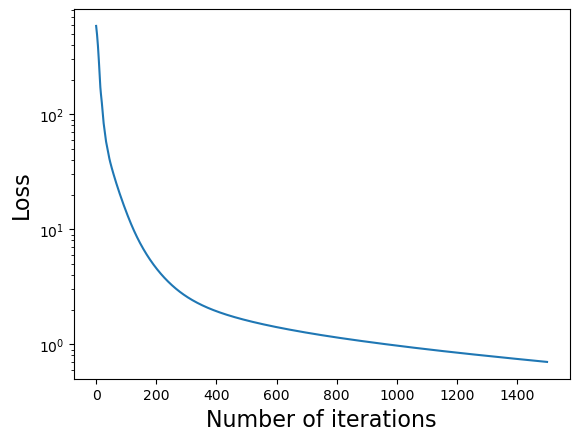

In [68]:
loss = sy.get_history()
print(loss.shape)


# Plot the loss
plt.figure()
plt.plot(loss[:])
plt.yscale('log')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)